In [1]:
import torch
import json
import torch
import os
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import random
import math
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


In [2]:
dataset_root = '/local/vondrick/ruoshi/objaverse/views_whole_sphere'

# dataset

In [19]:
class objaverse_sfm(Dataset):
    def __init__(self, root_dir, total_view, train=True, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        with open(os.path.join(root_dir, 'valid_paths.json')) as f:
            self.paths = json.load(f)
        random.shuffle(self.paths)
        self.total_view = total_view
        self.train = train
        total_objects = len(self.paths)
        if train:
            self.paths = self.paths[:math.floor(total_objects / 100. * 99.)] # used first 99% as training|
        else:
            self.paths = self.paths[math.floor(total_objects / 100. * 99.):] # used last 1% as validation
        
    def __len__(self):
        return len(self.img_labels)

    def __len__(self):
        return len(self.paths)
        
    def cartesian_to_spherical(self, xyz):
        ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
        xy = xyz[:,0]**2 + xyz[:,1]**2
        z = np.sqrt(xy + xyz[:,2]**2)
        theta = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
        #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
        azimuth = np.arctan2(xyz[:,1], xyz[:,0])
        return np.array([theta, azimuth, z])

    def get_T(self, target_RT, cond_RT):
        R, T = target_RT[:3, :3], target_RT[:, -1]
        T_target = -R.T @ T

        R, T = cond_RT[:3, :3], cond_RT[:, -1]
        T_cond = -R.T @ T

        theta_cond, azimuth_cond, z_cond = self.cartesian_to_spherical(T_cond[None, :])
        theta_target, azimuth_target, z_target = self.cartesian_to_spherical(T_target[None, :])
        
        d_theta = theta_target - theta_cond
        d_azimuth = (azimuth_target - azimuth_cond) % (2 * math.pi)
        d_z = z_target - z_cond
        
        d_T = torch.tensor([d_theta.item(), math.sin(d_azimuth.item()), math.cos(d_azimuth.item()), d_z.item()])
#         d_T = torch.tensor([d_theta.item(), d_azimuth.item(), d_z.item()])
        return d_T

    def load_im(self, path):
        '''
        replace background pixel with white in rendering
        '''
        img = plt.imread(path)
        img[img[:, :, -1] == 0.] = [1., 1., 1., 1.]
        img = Image.fromarray(np.uint8(img[:, :, :3] * 255.))
        return img

    def __getitem__(self, index):
        data = {}
        index_target, index_cond = random.sample(range(self.total_view), 2) # without replacement
        filename = os.path.join(self.root_dir, self.paths[index])

        # print(self.paths[index])

#         if self.return_paths:
#             data["path"] = str(filename)
            
        target_im = self.process_im(self.load_im(os.path.join(filename, '%03d.png' % index_target)))
        target_RT = np.load(os.path.join(filename, '%03d.npy' % index_target))
        cond_im = self.process_im(self.load_im(os.path.join(filename, '%03d.png' % index_cond)))
        cond_RT = np.load(os.path.join(filename, '%03d.npy' % index_cond))

        data["image_target"] = target_im
        data["image_cond"] = cond_im
        data["T"] = self.get_T(target_RT, cond_RT)
        return data
    
    def process_im(self, im):
        im = im.convert("RGB")
        im = self.transform(im)
        im = torchvision.transforms.functional.resize(im, 224)
        im = im * 2. - 1.
        return im

In [87]:
dataset = objaverse_sfm(dataset_root, 4, train=True, transform = ToTensor())

In [72]:
dataset[0]['image_target'].shape

torch.Size([3, 224, 224])

In [78]:
train_dataloader = DataLoader(objaverse_sfm(dataset_root, 4, train=True, transform = ToTensor()),\
                              batch_size=16, shuffle=True, num_workers=4)
test_dataloader = DataLoader(objaverse_sfm(dataset_root, 4, train=False, transform = ToTensor()),\
                             batch_size=16, shuffle=False, num_workers=4)

In [79]:
batch = next(iter(train_dataloader))

In [80]:
batch['image_target'].shape

torch.Size([16, 3, 224, 224])

# model

In [22]:
class sfm(torch.nn.Module):
    def __init__(self, resnet=False):
        super(sfm, self).__init__()
        
        if resnet:
            print('initializing resnet weights')
            self.cond_net = torchvision.models.resnet34(torchvision.models.ResNet34_Weights.DEFAULT)
            self.cond_net.fc = torch.nn.Sequential()
            self.target_net = torchvision.models.resnet34(torchvision.models.ResNet34_Weights.DEFAULT)
            self.target_net.fc = torch.nn.Sequential()
            self.linear1 = torch.nn.Linear(1024, 1024)
            self.activation = torch.nn.ReLU()
            self.linear2 = torch.nn.Linear(1024, 4)
    
        else:
            print('initializing vit weights')
            self.cond_net = torchvision.models.vit_b_16(torchvision.models.ViT_B_16_Weights.DEFAULT)
            self.cond_net.heads.head = torch.nn.Sequential()
            self.target_net = torchvision.models.vit_b_16(torchvision.models.ViT_B_16_Weights.DEFAULT)
            self.target_net.heads.head = torch.nn.Sequential()
            self.linear1 = torch.nn.Linear(768 * 2, 768 * 2)
            self.activation = torch.nn.ReLU()
            self.linear2 = torch.nn.Linear(768 * 2, 4)

    def forward(self, cond, target):
        cond_feature = self.cond_net(cond)
        target_feature = self.target_net(target)
        x = torch.cat([cond_feature, target_feature], dim=-1)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [14]:
model = sfm()

initializing vit weights


/home/rliu/ruoshi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(


In [30]:
image_target, image_cond, T = batch['image_target'], batch['image_cond'], batch['T']

In [31]:
image_target.shape, image_cond.shape, T.shape

(torch.Size([16, 3, 224, 224]),
 torch.Size([16, 3, 224, 224]),
 torch.Size([16, 3]))

In [32]:
pred = model(image_cond, image_target)

In [33]:
loss = ((pred - T) ** 2).mean()

In [82]:
# loss.backward()

In [7]:
train_dataloader = DataLoader(objaverse_sfm(dataset_root, 4, train=True, transform = ToTensor()),\
                              batch_size=64, shuffle=True, num_workers=8)
test_dataloader = DataLoader(objaverse_sfm(dataset_root, 4, train=False, transform = ToTensor()),\
                             batch_size=64, shuffle=False, num_workers=8)
azimuth = []
for i, batch in tqdm(enumerate(train_dataloader, 0), total=50):
    azimuth.append(batch['T'][:, 1])
    if i == 50:
        break

  0%|          | 0/50 [00:00<?, ?it/s]

(array([ 66.,  91.,  82.,  70.,  69.,  70.,  67., 100.,  95.,  73.,  98.,
         91.,  88.,  86.,  74.,  88.,  86.,  83.,  70.,  76.,  87.,  79.,
         84.,  80.,  88.,  86.,  75.,  77.,  82.,  69., 101.,  86.,  85.,
         92.,  67.,  80.,  76.,  74.,  88.,  85.]),
 array([4.5274809e-04, 1.5736596e-01, 3.1427917e-01, 4.7119239e-01,
        6.2810558e-01, 7.8501880e-01, 9.4193202e-01, 1.0988452e+00,
        1.2557585e+00, 1.4126717e+00, 1.5695848e+00, 1.7264981e+00,
        1.8834113e+00, 2.0403244e+00, 2.1972377e+00, 2.3541510e+00,
        2.5110643e+00, 2.6679773e+00, 2.8248906e+00, 2.9818039e+00,
        3.1387169e+00, 3.2956302e+00, 3.4525435e+00, 3.6094568e+00,
        3.7663698e+00, 3.9232831e+00, 4.0801964e+00, 4.2371097e+00,
        4.3940229e+00, 4.5509362e+00, 4.7078490e+00, 4.8647623e+00,
        5.0216756e+00, 5.1785889e+00, 5.3355021e+00, 5.4924154e+00,
        5.6493287e+00, 5.8062415e+00, 5.9631548e+00, 6.1200681e+00,
        6.2769814e+00], dtype=float32),
 <BarC

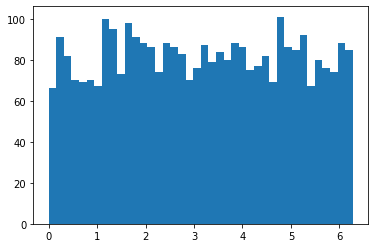

In [8]:
plt.hist(torch.cat(azimuth).numpy(), bins=40)

# training

## unzip files

In [35]:
# from sh import gunzip
# import json
# from tqdm.notebook import tqdm
# import os

# path = '/local/vondrick/ruoshi/objaverse/views_whole_sphere'
# with open('/local/vondrick/ruoshi/objaverse/views_whole_sphere/valid_paths.json') as f:
#     paths = json.load(f)
# total_view = 4
# for i, id in tqdm(enumerate(paths), total = len(paths)):
#     for filename in os.listdir(os.path.join(path, id)):
#         if 'gz' in filename:
# #             print(filename[:-3])
#             gunzip(os.path.join(path, id, filename[:-3]))

In [10]:
device = 0

In [ ]:
train_set = objaverse_sfm(dataset_root, 4, train=True, transform = ToTensor())
train_dataloader = DataLoader(train_set, batch_size=512, shuffle=True, num_workers=32, drop_last=False)

test_set = objaverse_sfm(dataset_root, 4, train=False, transform = ToTensor())
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=16, drop_last=False)

model = sfm(resnet=True).to(device)
model.cond_net.requires_grad_(False)
model.target_net.requires_grad_(False)
model = torch.nn.DataParallel(model, device_ids=[0, 1])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.01)

for epoch in range(50):  # loop over the dataset multiple times

    print('validation')
    model.eval()
    test_loss = torch.zeros(4).to(device)
    with torch.no_grad():
        for i, batch in tqdm(enumerate(test_dataloader, 0), total=len(test_dataloader)):
            # get the inputs; data is a list of [inputs, labels]
            image_target, image_cond, T_gt = \
                batch['image_target'].to(device), batch['image_cond'].to(device), batch['T'].to(device)

            # forward + backward + optimize
            T_pred = model(image_cond, image_target)
            loss = (T_pred - T_gt).abs()
            test_loss += loss.sum(dim=0)
    
    print('validation loss for epoch %d:' % epoch, test_loss.cpu() / len(test_set), test_loss.cpu().sum().item() / len(test_set))
    
    running_loss = torch.zeros(4).to(device)
    
    model.train()
    
    for i, batch in tqdm(enumerate(train_dataloader, 0), total=len(train_dataloader)):
        # get the inputs; data is a list of [inputs, labels]
        image_target, image_cond, T_gt = \
            batch['image_target'].to(device), batch['image_cond'].to(device), batch['T'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        T_pred = model(image_cond, image_target)
        loss = (T_pred - T_gt).abs()
        running_loss += loss.mean(dim=0)
        loss = loss.sum()
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 20 == 19:    # print every 2000 mini-batches
            print(f'[{i + 1}, {i + 20:5d}] loss: ', running_loss.detach().cpu() / 20, \
                  running_loss.detach().cpu().sum() / 20)
            running_loss = torch.zeros(4).to(device)
    

initializing resnet weights
validation


  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 0: tensor([0.7816, 0.6491, 0.6420, 0.4641]) 2.536709304920446


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.7545, 0.6441, 0.6587, 0.6656]) tensor(2.7229)
[40,    59] loss:  tensor([0.7104, 0.6433, 0.6376, 0.2364]) tensor(2.2277)
[60,    79] loss:  tensor([0.6262, 0.6404, 0.6379, 0.2265]) tensor(2.1311)
[80,    99] loss:  tensor([0.6019, 0.6353, 0.6397, 0.2195]) tensor(2.0963)
[100,   119] loss:  tensor([0.6130, 0.6386, 0.6356, 0.2049]) tensor(2.0921)
[120,   139] loss:  tensor([0.6031, 0.6380, 0.6379, 0.2027]) tensor(2.0817)
[140,   159] loss:  tensor([0.5960, 0.6350, 0.6390, 0.1989]) tensor(2.0689)
[160,   179] loss:  tensor([0.5846, 0.6327, 0.6406, 0.1959]) tensor(2.0539)
[180,   199] loss:  tensor([0.5876, 0.6397, 0.6374, 0.1920]) tensor(2.0567)
[200,   219] loss:  tensor([0.5836, 0.6380, 0.6366, 0.1924]) tensor(2.0505)
[220,   239] loss:  tensor([0.5822, 0.6383, 0.6348, 0.1915]) tensor(2.0467)
[240,   259] loss:  tensor([0.5841, 0.6344, 0.6389, 0.1892]) tensor(2.0466)
[260,   279] loss:  tensor([0.5823, 0.6388, 0.6322, 0.1887]) tensor(2.0420)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 1: tensor([0.5269, 0.6329, 0.6364, 0.1713]) 1.9674158213402029


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.5274, 0.6311, 0.6379, 0.1713]) tensor(1.9677)
[40,    59] loss:  tensor([0.5362, 0.6342, 0.6341, 0.1732]) tensor(1.9777)
[60,    79] loss:  tensor([0.5322, 0.6348, 0.6343, 0.1692]) tensor(1.9705)
[80,    99] loss:  tensor([0.5327, 0.6370, 0.6316, 0.1761]) tensor(1.9773)
[100,   119] loss:  tensor([0.5330, 0.6340, 0.6361, 0.1720]) tensor(1.9751)
[120,   139] loss:  tensor([0.5284, 0.6352, 0.6335, 0.1714]) tensor(1.9685)
[140,   159] loss:  tensor([0.5291, 0.6332, 0.6370, 0.1702]) tensor(1.9695)
[160,   179] loss:  tensor([0.5239, 0.6338, 0.6377, 0.1687]) tensor(1.9640)
[180,   199] loss:  tensor([0.5275, 0.6334, 0.6353, 0.1716]) tensor(1.9678)
[200,   219] loss:  tensor([0.5274, 0.6367, 0.6308, 0.1699]) tensor(1.9649)
[220,   239] loss:  tensor([0.5281, 0.6387, 0.6327, 0.1731]) tensor(1.9725)
[240,   259] loss:  tensor([0.5305, 0.6335, 0.6370, 0.1784]) tensor(1.9793)
[260,   279] loss:  tensor([0.5222, 0.6405, 0.6287, 0.1713]) tensor(1.9627)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 2: tensor([0.5093, 0.6369, 0.6322, 0.1700]) 1.9485235823571787


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.5188, 0.6333, 0.6335, 0.1676]) tensor(1.9532)
[40,    59] loss:  tensor([0.5055, 0.6369, 0.6329, 0.1652]) tensor(1.9404)
[60,    79] loss:  tensor([0.5055, 0.6358, 0.6341, 0.1649]) tensor(1.9403)
[80,    99] loss:  tensor([0.5218, 0.6360, 0.6329, 0.1671]) tensor(1.9577)
[100,   119] loss:  tensor([0.5137, 0.6330, 0.6376, 0.1638]) tensor(1.9482)
[120,   139] loss:  tensor([0.5090, 0.6329, 0.6355, 0.1658]) tensor(1.9432)
[140,   159] loss:  tensor([0.5133, 0.6337, 0.6345, 0.1664]) tensor(1.9479)
[160,   179] loss:  tensor([0.5117, 0.6346, 0.6320, 0.1666]) tensor(1.9449)
[180,   199] loss:  tensor([0.5113, 0.6348, 0.6347, 0.1671]) tensor(1.9480)
[200,   219] loss:  tensor([0.5116, 0.6345, 0.6314, 0.1683]) tensor(1.9459)
[220,   239] loss:  tensor([0.5014, 0.6346, 0.6335, 0.1681]) tensor(1.9376)
[240,   259] loss:  tensor([0.5033, 0.6328, 0.6340, 0.1656]) tensor(1.9357)
[260,   279] loss:  tensor([0.4956, 0.6372, 0.6339, 0.1649]) tensor(1.9317)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 3: tensor([0.5237, 0.6362, 0.6300, 0.1699]) 1.959776807386933


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.5077, 0.6358, 0.6323, 0.1641]) tensor(1.9399)
[40,    59] loss:  tensor([0.5025, 0.6372, 0.6316, 0.1649]) tensor(1.9361)
[60,    79] loss:  tensor([0.4985, 0.6333, 0.6356, 0.1640]) tensor(1.9314)
[80,    99] loss:  tensor([0.4958, 0.6387, 0.6295, 0.1657]) tensor(1.9297)
[100,   119] loss:  tensor([0.4907, 0.6365, 0.6303, 0.1657]) tensor(1.9233)
[120,   139] loss:  tensor([0.4987, 0.6371, 0.6266, 0.1626]) tensor(1.9249)
[140,   159] loss:  tensor([0.5021, 0.6370, 0.6339, 0.1638]) tensor(1.9368)
[160,   179] loss:  tensor([0.5004, 0.6343, 0.6331, 0.1634]) tensor(1.9312)
[180,   199] loss:  tensor([0.4995, 0.6301, 0.6356, 0.1629]) tensor(1.9281)
[200,   219] loss:  tensor([0.4959, 0.6287, 0.6372, 0.1631]) tensor(1.9249)
[220,   239] loss:  tensor([0.4942, 0.6365, 0.6293, 0.1629]) tensor(1.9229)
[240,   259] loss:  tensor([0.4981, 0.6378, 0.6306, 0.1632]) tensor(1.9297)
[260,   279] loss:  tensor([0.5005, 0.6352, 0.6333, 0.1628]) tensor(1.9319)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 4: tensor([0.4906, 0.6391, 0.6266, 0.1682]) 1.9245502086726385


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4866, 0.6350, 0.6355, 0.1616]) tensor(1.9187)
[40,    59] loss:  tensor([0.4844, 0.6391, 0.6291, 0.1627]) tensor(1.9154)
[60,    79] loss:  tensor([0.4883, 0.6369, 0.6301, 0.1625]) tensor(1.9179)
[80,    99] loss:  tensor([0.4967, 0.6344, 0.6326, 0.1620]) tensor(1.9257)
[100,   119] loss:  tensor([0.4892, 0.6331, 0.6343, 0.1598]) tensor(1.9164)
[120,   139] loss:  tensor([0.4879, 0.6327, 0.6363, 0.1612]) tensor(1.9181)
[140,   159] loss:  tensor([0.4863, 0.6313, 0.6333, 0.1621]) tensor(1.9129)
[160,   179] loss:  tensor([0.4913, 0.6330, 0.6323, 0.1623]) tensor(1.9189)
[180,   199] loss:  tensor([0.4942, 0.6396, 0.6258, 0.1628]) tensor(1.9223)
[200,   219] loss:  tensor([0.5012, 0.6379, 0.6313, 0.1642]) tensor(1.9346)
[220,   239] loss:  tensor([0.4910, 0.6390, 0.6287, 0.1613]) tensor(1.9200)
[240,   259] loss:  tensor([0.4975, 0.6400, 0.6264, 0.1613]) tensor(1.9253)
[260,   279] loss:  tensor([0.5003, 0.6409, 0.6267, 0.1633]) tensor(1.9312)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 5: tensor([0.5101, 0.6305, 0.6336, 0.1649]) 1.9391000356270358


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4924, 0.6372, 0.6296, 0.1628]) tensor(1.9219)
[40,    59] loss:  tensor([0.4956, 0.6302, 0.6330, 0.1605]) tensor(1.9193)
[60,    79] loss:  tensor([0.4915, 0.6360, 0.6292, 0.1635]) tensor(1.9202)
[80,    99] loss:  tensor([0.4829, 0.6322, 0.6348, 0.1644]) tensor(1.9143)
[100,   119] loss:  tensor([0.4880, 0.6380, 0.6294, 0.1610]) tensor(1.9165)
[120,   139] loss:  tensor([0.4873, 0.6315, 0.6335, 0.1618]) tensor(1.9141)
[140,   159] loss:  tensor([0.4861, 0.6405, 0.6259, 0.1606]) tensor(1.9131)
[160,   179] loss:  tensor([0.4844, 0.6364, 0.6292, 0.1603]) tensor(1.9102)
[180,   199] loss:  tensor([0.4796, 0.6332, 0.6316, 0.1614]) tensor(1.9057)
[200,   219] loss:  tensor([0.4828, 0.6348, 0.6335, 0.1591]) tensor(1.9103)
[220,   239] loss:  tensor([0.4812, 0.6371, 0.6294, 0.1628]) tensor(1.9105)
[240,   259] loss:  tensor([0.4925, 0.6380, 0.6294, 0.1592]) tensor(1.9191)
[260,   279] loss:  tensor([0.4890, 0.6343, 0.6321, 0.1618]) tensor(1.9172)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 6: tensor([0.4871, 0.6330, 0.6335, 0.1617]) 1.915201170406853


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4882, 0.6381, 0.6265, 0.1588]) tensor(1.9115)
[40,    59] loss:  tensor([0.4785, 0.6403, 0.6259, 0.1616]) tensor(1.9063)
[60,    79] loss:  tensor([0.4849, 0.6296, 0.6350, 0.1595]) tensor(1.9089)
[80,    99] loss:  tensor([0.4867, 0.6306, 0.6351, 0.1607]) tensor(1.9131)
[100,   119] loss:  tensor([0.4868, 0.6308, 0.6351, 0.1625]) tensor(1.9152)
[120,   139] loss:  tensor([0.4824, 0.6375, 0.6268, 0.1586]) tensor(1.9053)
[140,   159] loss:  tensor([0.4853, 0.6343, 0.6322, 0.1579]) tensor(1.9096)
[160,   179] loss:  tensor([0.4891, 0.6349, 0.6287, 0.1600]) tensor(1.9126)
[180,   199] loss:  tensor([0.4798, 0.6386, 0.6290, 0.1608]) tensor(1.9081)
[200,   219] loss:  tensor([0.4798, 0.6408, 0.6258, 0.1630]) tensor(1.9093)
[220,   239] loss:  tensor([0.4888, 0.6364, 0.6307, 0.1627]) tensor(1.9185)
[240,   259] loss:  tensor([0.4911, 0.6364, 0.6298, 0.1616]) tensor(1.9189)
[260,   279] loss:  tensor([0.4901, 0.6303, 0.6372, 0.1577]) tensor(1.9153)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 7: tensor([0.4807, 0.6355, 0.6332, 0.1648]) 1.914155360302869


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4831, 0.6375, 0.6288, 0.1607]) tensor(1.9101)
[40,    59] loss:  tensor([0.4788, 0.6351, 0.6298, 0.1587]) tensor(1.9023)
[60,    79] loss:  tensor([0.4889, 0.6319, 0.6340, 0.1601]) tensor(1.9148)
[80,    99] loss:  tensor([0.4811, 0.6339, 0.6358, 0.1607]) tensor(1.9115)
[100,   119] loss:  tensor([0.4771, 0.6341, 0.6305, 0.1598]) tensor(1.9015)
[120,   139] loss:  tensor([0.4826, 0.6362, 0.6280, 0.1608]) tensor(1.9077)
[140,   159] loss:  tensor([0.4763, 0.6351, 0.6332, 0.1613]) tensor(1.9060)
[160,   179] loss:  tensor([0.4825, 0.6382, 0.6279, 0.1601]) tensor(1.9088)
[180,   199] loss:  tensor([0.4821, 0.6345, 0.6295, 0.1572]) tensor(1.9033)
[200,   219] loss:  tensor([0.4835, 0.6320, 0.6309, 0.1571]) tensor(1.9035)
[220,   239] loss:  tensor([0.4787, 0.6316, 0.6327, 0.1593]) tensor(1.9023)
[240,   259] loss:  tensor([0.4833, 0.6293, 0.6356, 0.1571]) tensor(1.9053)
[260,   279] loss:  tensor([0.4791, 0.6300, 0.6359, 0.1583]) tensor(1.9034)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 8: tensor([0.4814, 0.6260, 0.6356, 0.1661]) 1.9091606015879479


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4831, 0.6379, 0.6249, 0.1622]) tensor(1.9081)
[40,    59] loss:  tensor([0.4718, 0.6330, 0.6331, 0.1595]) tensor(1.8974)
[60,    79] loss:  tensor([0.4806, 0.6429, 0.6227, 0.1618]) tensor(1.9080)
[80,    99] loss:  tensor([0.4739, 0.6383, 0.6265, 0.1597]) tensor(1.8984)
[100,   119] loss:  tensor([0.4727, 0.6380, 0.6260, 0.1606]) tensor(1.8972)
[120,   139] loss:  tensor([0.4829, 0.6357, 0.6264, 0.1608]) tensor(1.9058)
[140,   159] loss:  tensor([0.4744, 0.6318, 0.6323, 0.1573]) tensor(1.8958)
[160,   179] loss:  tensor([0.4699, 0.6364, 0.6272, 0.1577]) tensor(1.8912)
[180,   199] loss:  tensor([0.4785, 0.6349, 0.6320, 0.1579]) tensor(1.9033)
[200,   219] loss:  tensor([0.4785, 0.6367, 0.6292, 0.1593]) tensor(1.9036)
[220,   239] loss:  tensor([0.4809, 0.6296, 0.6337, 0.1593]) tensor(1.9035)
[240,   259] loss:  tensor([0.4757, 0.6343, 0.6310, 0.1575]) tensor(1.8986)
[260,   279] loss:  tensor([0.4765, 0.6365, 0.6282, 0.1568]) tensor(1.8979)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 9: tensor([0.4792, 0.6309, 0.6299, 0.1614]) 1.9014826817370334


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4736, 0.6441, 0.6168, 0.1550]) tensor(1.8895)
[40,    59] loss:  tensor([0.4809, 0.6371, 0.6280, 0.1610]) tensor(1.9069)
[60,    79] loss:  tensor([0.4701, 0.6366, 0.6301, 0.1579]) tensor(1.8947)
[80,    99] loss:  tensor([0.4775, 0.6413, 0.6277, 0.1572]) tensor(1.9037)
[100,   119] loss:  tensor([0.4738, 0.6329, 0.6304, 0.1568]) tensor(1.8939)
[120,   139] loss:  tensor([0.4807, 0.6343, 0.6279, 0.1575]) tensor(1.9003)
[140,   159] loss:  tensor([0.4847, 0.6345, 0.6289, 0.1597]) tensor(1.9078)
[160,   179] loss:  tensor([0.4790, 0.6431, 0.6242, 0.1583]) tensor(1.9046)
[180,   199] loss:  tensor([0.4793, 0.6323, 0.6325, 0.1581]) tensor(1.9021)
[200,   219] loss:  tensor([0.4815, 0.6385, 0.6253, 0.1596]) tensor(1.9048)
[220,   239] loss:  tensor([0.4687, 0.6309, 0.6337, 0.1620]) tensor(1.8952)
[240,   259] loss:  tensor([0.4761, 0.6408, 0.6263, 0.1607]) tensor(1.9039)
[260,   279] loss:  tensor([0.4744, 0.6351, 0.6290, 0.1591]) tensor(1.8975)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 10: tensor([0.4739, 0.6347, 0.6315, 0.1581]) 1.8981912183271736


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4736, 0.6306, 0.6315, 0.1570]) tensor(1.8927)
[40,    59] loss:  tensor([0.4718, 0.6328, 0.6340, 0.1597]) tensor(1.8984)
[60,    79] loss:  tensor([0.4714, 0.6327, 0.6281, 0.1567]) tensor(1.8889)
[80,    99] loss:  tensor([0.4762, 0.6276, 0.6355, 0.1569]) tensor(1.8962)
[100,   119] loss:  tensor([0.4865, 0.6366, 0.6285, 0.1588]) tensor(1.9105)
[120,   139] loss:  tensor([0.4751, 0.6364, 0.6278, 0.1598]) tensor(1.8992)
[140,   159] loss:  tensor([0.4683, 0.6324, 0.6321, 0.1561]) tensor(1.8890)
[160,   179] loss:  tensor([0.4738, 0.6380, 0.6322, 0.1563]) tensor(1.9002)
[180,   199] loss:  tensor([0.4760, 0.6352, 0.6315, 0.1557]) tensor(1.8984)
[200,   219] loss:  tensor([0.4682, 0.6393, 0.6265, 0.1556]) tensor(1.8896)
[220,   239] loss:  tensor([0.4789, 0.6370, 0.6296, 0.1559]) tensor(1.9015)
[240,   259] loss:  tensor([0.4749, 0.6373, 0.6253, 0.1576]) tensor(1.8952)
[260,   279] loss:  tensor([0.4772, 0.6378, 0.6249, 0.1562]) tensor(1.8961)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 11: tensor([0.4779, 0.6360, 0.6287, 0.1600]) 1.9025877071066148


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4736, 0.6413, 0.6224, 0.1556]) tensor(1.8930)
[40,    59] loss:  tensor([0.4768, 0.6322, 0.6318, 0.1595]) tensor(1.9003)
[60,    79] loss:  tensor([0.4708, 0.6274, 0.6361, 0.1604]) tensor(1.8947)
[80,    99] loss:  tensor([0.4785, 0.6349, 0.6327, 0.1569]) tensor(1.9030)
[100,   119] loss:  tensor([0.4745, 0.6315, 0.6328, 0.1571]) tensor(1.8959)
[120,   139] loss:  tensor([0.4709, 0.6347, 0.6291, 0.1572]) tensor(1.8919)
[140,   159] loss:  tensor([0.4661, 0.6295, 0.6310, 0.1569]) tensor(1.8834)
[160,   179] loss:  tensor([0.4773, 0.6401, 0.6241, 0.1599]) tensor(1.9015)
[180,   199] loss:  tensor([0.4725, 0.6349, 0.6278, 0.1567]) tensor(1.8920)
[200,   219] loss:  tensor([0.4696, 0.6379, 0.6275, 0.1560]) tensor(1.8909)
[220,   239] loss:  tensor([0.4767, 0.6405, 0.6256, 0.1599]) tensor(1.9026)
[240,   259] loss:  tensor([0.4708, 0.6401, 0.6248, 0.1605]) tensor(1.8962)
[260,   279] loss:  tensor([0.4759, 0.6374, 0.6254, 0.1595]) tensor(1.8982)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 12: tensor([0.4903, 0.6375, 0.6264, 0.1570]) 1.9112094008393887


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4727, 0.6346, 0.6319, 0.1581]) tensor(1.8972)
[40,    59] loss:  tensor([0.4658, 0.6366, 0.6296, 0.1572]) tensor(1.8893)
[60,    79] loss:  tensor([0.4747, 0.6274, 0.6367, 0.1562]) tensor(1.8950)
[80,    99] loss:  tensor([0.4729, 0.6370, 0.6244, 0.1578]) tensor(1.8922)
[100,   119] loss:  tensor([0.4718, 0.6353, 0.6279, 0.1554]) tensor(1.8905)
[120,   139] loss:  tensor([0.4765, 0.6383, 0.6238, 0.1598]) tensor(1.8984)
[140,   159] loss:  tensor([0.4776, 0.6348, 0.6253, 0.1552]) tensor(1.8928)
[160,   179] loss:  tensor([0.4730, 0.6404, 0.6259, 0.1570]) tensor(1.8963)
[180,   199] loss:  tensor([0.4709, 0.6357, 0.6287, 0.1555]) tensor(1.8907)
[200,   219] loss:  tensor([0.4801, 0.6366, 0.6260, 0.1573]) tensor(1.9000)
[220,   239] loss:  tensor([0.4640, 0.6320, 0.6341, 0.1571]) tensor(1.8872)
[240,   259] loss:  tensor([0.4675, 0.6339, 0.6274, 0.1553]) tensor(1.8841)
[260,   279] loss:  tensor([0.4718, 0.6327, 0.6313, 0.1591]) tensor(1.8949)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 13: tensor([0.4671, 0.6393, 0.6273, 0.1626]) 1.8963768332263218


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4628, 0.6386, 0.6240, 0.1587]) tensor(1.8841)
[40,    59] loss:  tensor([0.4816, 0.6349, 0.6267, 0.1554]) tensor(1.8985)
[60,    79] loss:  tensor([0.4688, 0.6341, 0.6300, 0.1562]) tensor(1.8891)
[80,    99] loss:  tensor([0.4695, 0.6402, 0.6248, 0.1564]) tensor(1.8909)
[100,   119] loss:  tensor([0.4711, 0.6306, 0.6335, 0.1553]) tensor(1.8905)
[120,   139] loss:  tensor([0.4740, 0.6334, 0.6314, 0.1574]) tensor(1.8963)
[140,   159] loss:  tensor([0.4648, 0.6334, 0.6313, 0.1552]) tensor(1.8847)
[160,   179] loss:  tensor([0.4653, 0.6374, 0.6264, 0.1561]) tensor(1.8852)
[180,   199] loss:  tensor([0.4717, 0.6428, 0.6220, 0.1577]) tensor(1.8943)
[200,   219] loss:  tensor([0.4627, 0.6358, 0.6300, 0.1568]) tensor(1.8854)
[220,   239] loss:  tensor([0.4754, 0.6393, 0.6293, 0.1577]) tensor(1.9017)
[240,   259] loss:  tensor([0.4640, 0.6353, 0.6256, 0.1577]) tensor(1.8826)
[260,   279] loss:  tensor([0.4817, 0.6374, 0.6256, 0.1589]) tensor(1.9036)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 14: tensor([0.4597, 0.6297, 0.6348, 0.1618]) 1.8859616754885993


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4637, 0.6354, 0.6268, 0.1536]) tensor(1.8795)
[40,    59] loss:  tensor([0.4687, 0.6345, 0.6278, 0.1565]) tensor(1.8876)
[60,    79] loss:  tensor([0.4732, 0.6310, 0.6328, 0.1572]) tensor(1.8942)
[80,    99] loss:  tensor([0.4740, 0.6382, 0.6243, 0.1549]) tensor(1.8915)
[100,   119] loss:  tensor([0.4661, 0.6350, 0.6329, 0.1552]) tensor(1.8891)
[120,   139] loss:  tensor([0.4739, 0.6357, 0.6280, 0.1572]) tensor(1.8949)
[140,   159] loss:  tensor([0.4753, 0.6374, 0.6267, 0.1557]) tensor(1.8951)
[160,   179] loss:  tensor([0.4730, 0.6355, 0.6259, 0.1574]) tensor(1.8917)
[180,   199] loss:  tensor([0.4599, 0.6400, 0.6221, 0.1644]) tensor(1.8864)
[200,   219] loss:  tensor([0.4775, 0.6329, 0.6307, 0.1580]) tensor(1.8991)
[220,   239] loss:  tensor([0.4691, 0.6325, 0.6269, 0.1580]) tensor(1.8865)
[240,   259] loss:  tensor([0.4686, 0.6374, 0.6274, 0.1583]) tensor(1.8918)
[260,   279] loss:  tensor([0.4687, 0.6428, 0.6233, 0.1571]) tensor(1.8919)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 15: tensor([0.4721, 0.6348, 0.6276, 0.1649]) 1.8994147965735404


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4761, 0.6312, 0.6311, 0.1580]) tensor(1.8964)
[40,    59] loss:  tensor([0.4689, 0.6374, 0.6288, 0.1581]) tensor(1.8931)
[60,    79] loss:  tensor([0.4701, 0.6358, 0.6246, 0.1569]) tensor(1.8875)
[80,    99] loss:  tensor([0.4612, 0.6338, 0.6303, 0.1551]) tensor(1.8806)
[100,   119] loss:  tensor([0.4754, 0.6348, 0.6285, 0.1560]) tensor(1.8947)
[120,   139] loss:  tensor([0.4678, 0.6338, 0.6311, 0.1558]) tensor(1.8886)
[140,   159] loss:  tensor([0.4620, 0.6439, 0.6151, 0.1550]) tensor(1.8760)
[160,   179] loss:  tensor([0.4652, 0.6365, 0.6268, 0.1551]) tensor(1.8836)
[180,   199] loss:  tensor([0.4708, 0.6385, 0.6277, 0.1565]) tensor(1.8935)
[200,   219] loss:  tensor([0.4748, 0.6376, 0.6269, 0.1552]) tensor(1.8946)
[220,   239] loss:  tensor([0.4639, 0.6339, 0.6292, 0.1560]) tensor(1.8830)
[240,   259] loss:  tensor([0.4707, 0.6342, 0.6286, 0.1553]) tensor(1.8888)
[260,   279] loss:  tensor([0.4711, 0.6373, 0.6253, 0.1562]) tensor(1.8899)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 16: tensor([0.4698, 0.6368, 0.6282, 0.1590]) 1.8937697710473564


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4694, 0.6402, 0.6231, 0.1551]) tensor(1.8879)
[40,    59] loss:  tensor([0.4708, 0.6354, 0.6263, 0.1546]) tensor(1.8872)
[60,    79] loss:  tensor([0.4675, 0.6384, 0.6241, 0.1577]) tensor(1.8876)
[80,    99] loss:  tensor([0.4715, 0.6299, 0.6322, 0.1562]) tensor(1.8897)
[100,   119] loss:  tensor([0.4792, 0.6308, 0.6318, 0.1550]) tensor(1.8967)
[120,   139] loss:  tensor([0.4652, 0.6405, 0.6264, 0.1550]) tensor(1.8872)
[140,   159] loss:  tensor([0.4757, 0.6391, 0.6252, 0.1587]) tensor(1.8986)
[160,   179] loss:  tensor([0.4778, 0.6350, 0.6272, 0.1538]) tensor(1.8938)
[180,   199] loss:  tensor([0.4725, 0.6343, 0.6283, 0.1561]) tensor(1.8912)
[200,   219] loss:  tensor([0.4717, 0.6361, 0.6252, 0.1573]) tensor(1.8904)
[220,   239] loss:  tensor([0.4610, 0.6347, 0.6287, 0.1558]) tensor(1.8803)
[240,   259] loss:  tensor([0.4669, 0.6396, 0.6259, 0.1570]) tensor(1.8894)
[260,   279] loss:  tensor([0.4784, 0.6344, 0.6285, 0.1576]) tensor(1.8990)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 17: tensor([0.4651, 0.6323, 0.6299, 0.1576]) 1.8848469848174016


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4682, 0.6331, 0.6289, 0.1549]) tensor(1.8851)
[40,    59] loss:  tensor([0.4691, 0.6335, 0.6274, 0.1535]) tensor(1.8834)
[60,    79] loss:  tensor([0.4695, 0.6376, 0.6258, 0.1570]) tensor(1.8898)
[80,    99] loss:  tensor([0.4641, 0.6321, 0.6289, 0.1565]) tensor(1.8815)
[100,   119] loss:  tensor([0.4685, 0.6389, 0.6256, 0.1562]) tensor(1.8892)
[120,   139] loss:  tensor([0.4639, 0.6372, 0.6278, 0.1558]) tensor(1.8847)
[140,   159] loss:  tensor([0.4685, 0.6381, 0.6252, 0.1566]) tensor(1.8885)
[160,   179] loss:  tensor([0.4640, 0.6387, 0.6249, 0.1536]) tensor(1.8812)
[180,   199] loss:  tensor([0.4578, 0.6335, 0.6307, 0.1564]) tensor(1.8783)
[200,   219] loss:  tensor([0.4657, 0.6386, 0.6252, 0.1553]) tensor(1.8849)
[220,   239] loss:  tensor([0.4658, 0.6373, 0.6259, 0.1539]) tensor(1.8829)
[240,   259] loss:  tensor([0.4715, 0.6406, 0.6231, 0.1551]) tensor(1.8903)
[260,   279] loss:  tensor([0.4628, 0.6353, 0.6271, 0.1559]) tensor(1.8812)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 18: tensor([0.4725, 0.6319, 0.6319, 0.1566]) 1.8929737906383113


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4564, 0.6376, 0.6283, 0.1541]) tensor(1.8764)
[40,    59] loss:  tensor([0.4712, 0.6310, 0.6308, 0.1567]) tensor(1.8897)
[60,    79] loss:  tensor([0.4731, 0.6331, 0.6271, 0.1556]) tensor(1.8889)
[80,    99] loss:  tensor([0.4597, 0.6355, 0.6276, 0.1555]) tensor(1.8784)
[100,   119] loss:  tensor([0.4600, 0.6368, 0.6259, 0.1534]) tensor(1.8761)
[120,   139] loss:  tensor([0.4616, 0.6397, 0.6231, 0.1550]) tensor(1.8795)
[140,   159] loss:  tensor([0.4708, 0.6353, 0.6292, 0.1559]) tensor(1.8912)
[160,   179] loss:  tensor([0.4691, 0.6342, 0.6281, 0.1559]) tensor(1.8873)
[180,   199] loss:  tensor([0.4611, 0.6335, 0.6308, 0.1558]) tensor(1.8811)
[200,   219] loss:  tensor([0.4660, 0.6359, 0.6280, 0.1562]) tensor(1.8861)
[220,   239] loss:  tensor([0.4726, 0.6399, 0.6251, 0.1546]) tensor(1.8923)
[240,   259] loss:  tensor([0.4783, 0.6373, 0.6254, 0.1561]) tensor(1.8971)
[260,   279] loss:  tensor([0.4666, 0.6338, 0.6264, 0.1556]) tensor(1.8824)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 19: tensor([0.5003, 0.6387, 0.6266, 0.1561]) 1.9216352026434478


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4787, 0.6327, 0.6295, 0.1514]) tensor(1.8923)
[40,    59] loss:  tensor([0.4698, 0.6404, 0.6205, 0.1557]) tensor(1.8865)
[60,    79] loss:  tensor([0.4752, 0.6364, 0.6277, 0.1576]) tensor(1.8968)
[80,    99] loss:  tensor([0.4597, 0.6363, 0.6259, 0.1547]) tensor(1.8765)
[100,   119] loss:  tensor([0.4603, 0.6321, 0.6365, 0.1574]) tensor(1.8862)
[120,   139] loss:  tensor([0.4633, 0.6383, 0.6261, 0.1546]) tensor(1.8823)
[140,   159] loss:  tensor([0.4735, 0.6371, 0.6252, 0.1568]) tensor(1.8925)
[160,   179] loss:  tensor([0.4673, 0.6375, 0.6265, 0.1556]) tensor(1.8869)
[180,   199] loss:  tensor([0.4608, 0.6355, 0.6255, 0.1548]) tensor(1.8766)
[200,   219] loss:  tensor([0.4637, 0.6371, 0.6263, 0.1554]) tensor(1.8824)
[220,   239] loss:  tensor([0.4590, 0.6310, 0.6319, 0.1562]) tensor(1.8781)
[240,   259] loss:  tensor([0.4678, 0.6379, 0.6271, 0.1568]) tensor(1.8897)
[260,   279] loss:  tensor([0.4612, 0.6365, 0.6250, 0.1547]) tensor(1.8774)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 20: tensor([0.4635, 0.6395, 0.6215, 0.1558]) 1.8802543760570658


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4571, 0.6331, 0.6281, 0.1536]) tensor(1.8720)
[40,    59] loss:  tensor([0.4654, 0.6320, 0.6309, 0.1540]) tensor(1.8822)
[60,    79] loss:  tensor([0.4574, 0.6376, 0.6254, 0.1585]) tensor(1.8788)
[80,    99] loss:  tensor([0.4612, 0.6412, 0.6197, 0.1558]) tensor(1.8779)
[100,   119] loss:  tensor([0.4647, 0.6348, 0.6281, 0.1561]) tensor(1.8837)
[120,   139] loss:  tensor([0.4650, 0.6394, 0.6229, 0.1569]) tensor(1.8842)
[140,   159] loss:  tensor([0.4786, 0.6364, 0.6276, 0.1545]) tensor(1.8970)
[160,   179] loss:  tensor([0.4633, 0.6395, 0.6219, 0.1563]) tensor(1.8811)
[180,   199] loss:  tensor([0.4628, 0.6313, 0.6301, 0.1548]) tensor(1.8790)
[200,   219] loss:  tensor([0.4583, 0.6384, 0.6246, 0.1577]) tensor(1.8791)
[220,   239] loss:  tensor([0.4562, 0.6377, 0.6234, 0.1573]) tensor(1.8747)
[240,   259] loss:  tensor([0.4589, 0.6371, 0.6267, 0.1565]) tensor(1.8791)
[260,   279] loss:  tensor([0.4590, 0.6392, 0.6249, 0.1549]) tensor(1.8780)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 21: tensor([0.4759, 0.6407, 0.6209, 0.1555]) 1.892975258785392


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4660, 0.6321, 0.6312, 0.1539]) tensor(1.8831)
[40,    59] loss:  tensor([0.4671, 0.6331, 0.6281, 0.1544]) tensor(1.8828)
[60,    79] loss:  tensor([0.4563, 0.6381, 0.6241, 0.1552]) tensor(1.8737)
[80,    99] loss:  tensor([0.4684, 0.6341, 0.6306, 0.1557]) tensor(1.8888)
[100,   119] loss:  tensor([0.4623, 0.6358, 0.6285, 0.1557]) tensor(1.8823)
[120,   139] loss:  tensor([0.4628, 0.6334, 0.6279, 0.1561]) tensor(1.8802)
[140,   159] loss:  tensor([0.4640, 0.6341, 0.6246, 0.1534]) tensor(1.8760)
[160,   179] loss:  tensor([0.4579, 0.6359, 0.6260, 0.1543]) tensor(1.8741)
[180,   199] loss:  tensor([0.4626, 0.6330, 0.6263, 0.1532]) tensor(1.8751)
[200,   219] loss:  tensor([0.4645, 0.6407, 0.6249, 0.1567]) tensor(1.8868)
[220,   239] loss:  tensor([0.4625, 0.6330, 0.6299, 0.1539]) tensor(1.8793)
[240,   259] loss:  tensor([0.4553, 0.6349, 0.6274, 0.1538]) tensor(1.8714)
[260,   279] loss:  tensor([0.4704, 0.6332, 0.6314, 0.1528]) tensor(1.8877)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 22: tensor([0.4634, 0.6316, 0.6295, 0.1564]) 1.8808741788163994


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4678, 0.6370, 0.6267, 0.1554]) tensor(1.8870)
[40,    59] loss:  tensor([0.4615, 0.6289, 0.6335, 0.1544]) tensor(1.8782)
[60,    79] loss:  tensor([0.4619, 0.6316, 0.6296, 0.1557]) tensor(1.8787)
[80,    99] loss:  tensor([0.4614, 0.6360, 0.6271, 0.1556]) tensor(1.8801)
[100,   119] loss:  tensor([0.4613, 0.6344, 0.6290, 0.1563]) tensor(1.8810)
[120,   139] loss:  tensor([0.4649, 0.6371, 0.6267, 0.1551]) tensor(1.8838)
[140,   159] loss:  tensor([0.4658, 0.6334, 0.6304, 0.1548]) tensor(1.8844)
[160,   179] loss:  tensor([0.4648, 0.6331, 0.6316, 0.1543]) tensor(1.8837)
[180,   199] loss:  tensor([0.4671, 0.6327, 0.6282, 0.1557]) tensor(1.8837)
[200,   219] loss:  tensor([0.4642, 0.6292, 0.6309, 0.1551]) tensor(1.8795)
[220,   239] loss:  tensor([0.4635, 0.6321, 0.6285, 0.1570]) tensor(1.8812)
[240,   259] loss:  tensor([0.4626, 0.6330, 0.6270, 0.1542]) tensor(1.8768)
[260,   279] loss:  tensor([0.4640, 0.6351, 0.6228, 0.1562]) tensor(1.8782)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 23: tensor([0.4623, 0.6342, 0.6248, 0.1702]) 1.8914557265566274


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4594, 0.6355, 0.6275, 0.1608]) tensor(1.8833)
[40,    59] loss:  tensor([0.4689, 0.6370, 0.6246, 0.1511]) tensor(1.8816)
[60,    79] loss:  tensor([0.4609, 0.6336, 0.6281, 0.1525]) tensor(1.8751)
[80,    99] loss:  tensor([0.4622, 0.6367, 0.6267, 0.1552]) tensor(1.8809)
[100,   119] loss:  tensor([0.4644, 0.6376, 0.6263, 0.1556]) tensor(1.8838)
[120,   139] loss:  tensor([0.4646, 0.6388, 0.6245, 0.1515]) tensor(1.8793)
[140,   159] loss:  tensor([0.4635, 0.6322, 0.6270, 0.1548]) tensor(1.8776)
[160,   179] loss:  tensor([0.4583, 0.6322, 0.6304, 0.1553]) tensor(1.8762)
[180,   199] loss:  tensor([0.4589, 0.6359, 0.6270, 0.1551]) tensor(1.8769)
[200,   219] loss:  tensor([0.4636, 0.6335, 0.6255, 0.1566]) tensor(1.8792)
[220,   239] loss:  tensor([0.4671, 0.6335, 0.6296, 0.1558]) tensor(1.8859)
[240,   259] loss:  tensor([0.4685, 0.6328, 0.6272, 0.1537]) tensor(1.8822)
[260,   279] loss:  tensor([0.4699, 0.6347, 0.6249, 0.1531]) tensor(1.8826)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 24: tensor([0.4643, 0.6339, 0.6295, 0.1565]) 1.8841908454178151


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4517, 0.6350, 0.6254, 0.1552]) tensor(1.8674)
[40,    59] loss:  tensor([0.4575, 0.6361, 0.6254, 0.1522]) tensor(1.8712)
[60,    79] loss:  tensor([0.4702, 0.6356, 0.6298, 0.1558]) tensor(1.8913)
[80,    99] loss:  tensor([0.4652, 0.6345, 0.6247, 0.1532]) tensor(1.8776)
[100,   119] loss:  tensor([0.4604, 0.6338, 0.6290, 0.1553]) tensor(1.8786)
[120,   139] loss:  tensor([0.4641, 0.6331, 0.6284, 0.1584]) tensor(1.8840)
[140,   159] loss:  tensor([0.4602, 0.6360, 0.6256, 0.1557]) tensor(1.8776)
[160,   179] loss:  tensor([0.4625, 0.6365, 0.6246, 0.1541]) tensor(1.8776)
[180,   199] loss:  tensor([0.4598, 0.6382, 0.6226, 0.1539]) tensor(1.8746)
[200,   219] loss:  tensor([0.4618, 0.6384, 0.6263, 0.1551]) tensor(1.8816)
[220,   239] loss:  tensor([0.4593, 0.6375, 0.6237, 0.1536]) tensor(1.8739)
[240,   259] loss:  tensor([0.4618, 0.6349, 0.6266, 0.1556]) tensor(1.8789)
[260,   279] loss:  tensor([0.4607, 0.6398, 0.6231, 0.1579]) tensor(1.8816)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 25: tensor([0.4617, 0.6381, 0.6268, 0.1581]) 1.8847349162568905


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4660, 0.6374, 0.6286, 0.1573]) tensor(1.8893)
[40,    59] loss:  tensor([0.4588, 0.6286, 0.6334, 0.1535]) tensor(1.8743)
[60,    79] loss:  tensor([0.4573, 0.6327, 0.6310, 0.1560]) tensor(1.8770)
[80,    99] loss:  tensor([0.4541, 0.6332, 0.6287, 0.1549]) tensor(1.8709)
[100,   119] loss:  tensor([0.4540, 0.6394, 0.6225, 0.1544]) tensor(1.8704)
[120,   139] loss:  tensor([0.4552, 0.6322, 0.6287, 0.1532]) tensor(1.8694)
[140,   159] loss:  tensor([0.4658, 0.6404, 0.6241, 0.1536]) tensor(1.8839)
[160,   179] loss:  tensor([0.4671, 0.6320, 0.6318, 0.1563]) tensor(1.8872)
[180,   199] loss:  tensor([0.4532, 0.6316, 0.6299, 0.1536]) tensor(1.8682)
[200,   219] loss:  tensor([0.4575, 0.6382, 0.6234, 0.1541]) tensor(1.8732)
[220,   239] loss:  tensor([0.4586, 0.6356, 0.6244, 0.1552]) tensor(1.8739)
[240,   259] loss:  tensor([0.4640, 0.6301, 0.6321, 0.1537]) tensor(1.8798)
[260,   279] loss:  tensor([0.4638, 0.6384, 0.6205, 0.1532]) tensor(1.8758)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 26: tensor([0.4663, 0.6393, 0.6207, 0.1623]) 1.8886909609120521


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4593, 0.6403, 0.6255, 0.1554]) tensor(1.8805)
[40,    59] loss:  tensor([0.4628, 0.6366, 0.6241, 0.1545]) tensor(1.8780)
[60,    79] loss:  tensor([0.4658, 0.6356, 0.6283, 0.1544]) tensor(1.8840)
[80,    99] loss:  tensor([0.4589, 0.6349, 0.6288, 0.1532]) tensor(1.8757)
[100,   119] loss:  tensor([0.4695, 0.6377, 0.6267, 0.1552]) tensor(1.8891)
[120,   139] loss:  tensor([0.4535, 0.6353, 0.6263, 0.1557]) tensor(1.8707)
[140,   159] loss:  tensor([0.4583, 0.6346, 0.6244, 0.1553]) tensor(1.8726)
[160,   179] loss:  tensor([0.4605, 0.6335, 0.6312, 0.1562]) tensor(1.8814)
[180,   199] loss:  tensor([0.4619, 0.6365, 0.6251, 0.1558]) tensor(1.8794)
[200,   219] loss:  tensor([0.4632, 0.6378, 0.6227, 0.1572]) tensor(1.8809)
[220,   239] loss:  tensor([0.4652, 0.6334, 0.6291, 0.1557]) tensor(1.8833)
[240,   259] loss:  tensor([0.4597, 0.6287, 0.6339, 0.1570]) tensor(1.8794)
[260,   279] loss:  tensor([0.4557, 0.6319, 0.6292, 0.1538]) tensor(1.8706)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 27: tensor([0.4655, 0.6359, 0.6260, 0.1583]) 1.8856992441978828


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4674, 0.6356, 0.6267, 0.1541]) tensor(1.8838)
[40,    59] loss:  tensor([0.4659, 0.6404, 0.6201, 0.1555]) tensor(1.8819)
[60,    79] loss:  tensor([0.4579, 0.6393, 0.6210, 0.1556]) tensor(1.8737)
[80,    99] loss:  tensor([0.4622, 0.6355, 0.6269, 0.1534]) tensor(1.8780)
[100,   119] loss:  tensor([0.4553, 0.6348, 0.6237, 0.1541]) tensor(1.8679)
[120,   139] loss:  tensor([0.4563, 0.6379, 0.6235, 0.1541]) tensor(1.8718)
[140,   159] loss:  tensor([0.4542, 0.6368, 0.6250, 0.1566]) tensor(1.8726)
[160,   179] loss:  tensor([0.4614, 0.6342, 0.6256, 0.1529]) tensor(1.8741)
[180,   199] loss:  tensor([0.4589, 0.6317, 0.6277, 0.1559]) tensor(1.8743)
[200,   219] loss:  tensor([0.4545, 0.6309, 0.6276, 0.1574]) tensor(1.8704)
[220,   239] loss:  tensor([0.4745, 0.6391, 0.6221, 0.1563]) tensor(1.8921)
[240,   259] loss:  tensor([0.4640, 0.6328, 0.6303, 0.1553]) tensor(1.8825)
[260,   279] loss:  tensor([0.4551, 0.6397, 0.6236, 0.1531]) tensor(1.8714)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 28: tensor([0.4661, 0.6395, 0.6219, 0.1561]) 1.8836858028219745


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4529, 0.6378, 0.6257, 0.1530]) tensor(1.8693)
[40,    59] loss:  tensor([0.4523, 0.6361, 0.6256, 0.1525]) tensor(1.8664)
[60,    79] loss:  tensor([0.4616, 0.6365, 0.6239, 0.1539]) tensor(1.8759)
[80,    99] loss:  tensor([0.4571, 0.6385, 0.6219, 0.1527]) tensor(1.8703)
[100,   119] loss:  tensor([0.4580, 0.6365, 0.6237, 0.1548]) tensor(1.8730)
[120,   139] loss:  tensor([0.4559, 0.6349, 0.6257, 0.1527]) tensor(1.8692)
[140,   159] loss:  tensor([0.4614, 0.6383, 0.6240, 0.1545]) tensor(1.8782)
[160,   179] loss:  tensor([0.4616, 0.6419, 0.6223, 0.1541]) tensor(1.8799)
[180,   199] loss:  tensor([0.4630, 0.6375, 0.6257, 0.1553]) tensor(1.8816)
[200,   219] loss:  tensor([0.4701, 0.6406, 0.6248, 0.1555]) tensor(1.8910)
[220,   239] loss:  tensor([0.4632, 0.6334, 0.6296, 0.1537]) tensor(1.8799)
[240,   259] loss:  tensor([0.4510, 0.6291, 0.6329, 0.1539]) tensor(1.8670)
[260,   279] loss:  tensor([0.4578, 0.6359, 0.6236, 0.1528]) tensor(1.8701)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 29: tensor([0.4609, 0.6328, 0.6236, 0.1557]) 1.87312566556001


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4639, 0.6352, 0.6288, 0.1543]) tensor(1.8823)
[40,    59] loss:  tensor([0.4599, 0.6349, 0.6261, 0.1540]) tensor(1.8749)
[60,    79] loss:  tensor([0.4627, 0.6368, 0.6246, 0.1550]) tensor(1.8791)
[80,    99] loss:  tensor([0.4585, 0.6373, 0.6234, 0.1560]) tensor(1.8751)
[100,   119] loss:  tensor([0.4608, 0.6347, 0.6285, 0.1551]) tensor(1.8792)
[120,   139] loss:  tensor([0.4605, 0.6383, 0.6232, 0.1563]) tensor(1.8782)
[140,   159] loss:  tensor([0.4552, 0.6350, 0.6258, 0.1548]) tensor(1.8708)
[160,   179] loss:  tensor([0.4596, 0.6357, 0.6265, 0.1530]) tensor(1.8748)
[180,   199] loss:  tensor([0.4541, 0.6351, 0.6285, 0.1543]) tensor(1.8720)
[200,   219] loss:  tensor([0.4562, 0.6316, 0.6270, 0.1534]) tensor(1.8682)
[220,   239] loss:  tensor([0.4624, 0.6330, 0.6280, 0.1520]) tensor(1.8754)
[240,   259] loss:  tensor([0.4545, 0.6339, 0.6269, 0.1524]) tensor(1.8678)
[260,   279] loss:  tensor([0.4631, 0.6361, 0.6276, 0.1535]) tensor(1.8804)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 30: tensor([0.4668, 0.6386, 0.6249, 0.1581]) 1.8883976985326358


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4612, 0.6336, 0.6267, 0.1534]) tensor(1.8750)
[40,    59] loss:  tensor([0.4583, 0.6358, 0.6247, 0.1528]) tensor(1.8715)
[60,    79] loss:  tensor([0.4556, 0.6346, 0.6273, 0.1529]) tensor(1.8704)
[80,    99] loss:  tensor([0.4641, 0.6381, 0.6234, 0.1508]) tensor(1.8764)
[100,   119] loss:  tensor([0.4597, 0.6391, 0.6227, 0.1547]) tensor(1.8761)
[120,   139] loss:  tensor([0.4538, 0.6353, 0.6247, 0.1552]) tensor(1.8689)
[140,   159] loss:  tensor([0.4586, 0.6381, 0.6231, 0.1522]) tensor(1.8719)
[160,   179] loss:  tensor([0.4619, 0.6352, 0.6243, 0.1544]) tensor(1.8758)
[180,   199] loss:  tensor([0.4587, 0.6396, 0.6184, 0.1551]) tensor(1.8718)
[200,   219] loss:  tensor([0.4596, 0.6354, 0.6263, 0.1534]) tensor(1.8746)
[220,   239] loss:  tensor([0.4663, 0.6365, 0.6248, 0.1539]) tensor(1.8815)
[240,   259] loss:  tensor([0.4596, 0.6329, 0.6266, 0.1545]) tensor(1.8735)
[260,   279] loss:  tensor([0.4586, 0.6389, 0.6202, 0.1530]) tensor(1.8707)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 31: tensor([0.4589, 0.6313, 0.6292, 0.1549]) 1.8742538142461163


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4649, 0.6364, 0.6240, 0.1541]) tensor(1.8794)
[40,    59] loss:  tensor([0.4600, 0.6335, 0.6308, 0.1558]) tensor(1.8802)
[60,    79] loss:  tensor([0.4554, 0.6366, 0.6205, 0.1543]) tensor(1.8668)
[80,    99] loss:  tensor([0.4606, 0.6314, 0.6281, 0.1535]) tensor(1.8735)
[100,   119] loss:  tensor([0.4622, 0.6350, 0.6240, 0.1567]) tensor(1.8779)
[120,   139] loss:  tensor([0.4577, 0.6346, 0.6249, 0.1553]) tensor(1.8726)
[140,   159] loss:  tensor([0.4592, 0.6356, 0.6243, 0.1551]) tensor(1.8742)
[160,   179] loss:  tensor([0.4540, 0.6368, 0.6227, 0.1575]) tensor(1.8709)
[180,   199] loss:  tensor([0.4605, 0.6378, 0.6264, 0.1558]) tensor(1.8805)
[200,   219] loss:  tensor([0.4595, 0.6335, 0.6284, 0.1560]) tensor(1.8773)
[220,   239] loss:  tensor([0.4620, 0.6375, 0.6259, 0.1574]) tensor(1.8827)
[240,   259] loss:  tensor([0.4601, 0.6422, 0.6223, 0.1561]) tensor(1.8806)
[260,   279] loss:  tensor([0.4637, 0.6283, 0.6309, 0.1534]) tensor(1.8764)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 32: tensor([0.4583, 0.6308, 0.6318, 0.1574]) 1.8783192358588072


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4580, 0.6354, 0.6253, 0.1544]) tensor(1.8731)
[40,    59] loss:  tensor([0.4506, 0.6360, 0.6273, 0.1522]) tensor(1.8662)
[60,    79] loss:  tensor([0.4569, 0.6331, 0.6276, 0.1536]) tensor(1.8711)
[80,    99] loss:  tensor([0.4562, 0.6370, 0.6223, 0.1538]) tensor(1.8693)
[100,   119] loss:  tensor([0.4535, 0.6374, 0.6221, 0.1534]) tensor(1.8663)
[120,   139] loss:  tensor([0.4600, 0.6341, 0.6291, 0.1512]) tensor(1.8743)
[140,   159] loss:  tensor([0.4575, 0.6379, 0.6264, 0.1569]) tensor(1.8788)
[160,   179] loss:  tensor([0.4624, 0.6271, 0.6323, 0.1517]) tensor(1.8736)
[180,   199] loss:  tensor([0.4573, 0.6351, 0.6262, 0.1564]) tensor(1.8749)
[200,   219] loss:  tensor([0.4544, 0.6409, 0.6213, 0.1541]) tensor(1.8707)
[220,   239] loss:  tensor([0.4713, 0.6362, 0.6248, 0.1522]) tensor(1.8844)
[240,   259] loss:  tensor([0.4589, 0.6333, 0.6259, 0.1539]) tensor(1.8720)
[260,   279] loss:  tensor([0.4590, 0.6355, 0.6253, 0.1540]) tensor(1.8738)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 33: tensor([0.4606, 0.6342, 0.6243, 0.1547]) 1.8737988109966175


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4595, 0.6374, 0.6263, 0.1574]) tensor(1.8805)
[40,    59] loss:  tensor([0.4540, 0.6352, 0.6246, 0.1550]) tensor(1.8688)
[60,    79] loss:  tensor([0.4563, 0.6347, 0.6250, 0.1528]) tensor(1.8689)
[80,    99] loss:  tensor([0.4624, 0.6354, 0.6280, 0.1532]) tensor(1.8790)
[100,   119] loss:  tensor([0.4522, 0.6409, 0.6215, 0.1576]) tensor(1.8722)
[120,   139] loss:  tensor([0.4643, 0.6360, 0.6235, 0.1523]) tensor(1.8762)
[140,   159] loss:  tensor([0.4617, 0.6388, 0.6201, 0.1536]) tensor(1.8743)
[160,   179] loss:  tensor([0.4499, 0.6374, 0.6241, 0.1559]) tensor(1.8673)
[180,   199] loss:  tensor([0.4546, 0.6335, 0.6254, 0.1531]) tensor(1.8666)
[200,   219] loss:  tensor([0.4599, 0.6370, 0.6272, 0.1534]) tensor(1.8775)
[220,   239] loss:  tensor([0.4630, 0.6355, 0.6224, 0.1525]) tensor(1.8734)
[240,   259] loss:  tensor([0.4637, 0.6323, 0.6283, 0.1516]) tensor(1.8758)
[260,   279] loss:  tensor([0.4682, 0.6388, 0.6257, 0.1536]) tensor(1.8862)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 34: tensor([0.4564, 0.6310, 0.6289, 0.1537]) 1.8699861553730268


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4559, 0.6373, 0.6246, 0.1554]) tensor(1.8732)
[40,    59] loss:  tensor([0.4611, 0.6374, 0.6218, 0.1539]) tensor(1.8742)
[60,    79] loss:  tensor([0.4604, 0.6357, 0.6181, 0.1532]) tensor(1.8674)
[80,    99] loss:  tensor([0.4538, 0.6364, 0.6270, 0.1545]) tensor(1.8717)
[100,   119] loss:  tensor([0.4592, 0.6348, 0.6253, 0.1513]) tensor(1.8707)
[120,   139] loss:  tensor([0.4604, 0.6381, 0.6254, 0.1575]) tensor(1.8814)
[140,   159] loss:  tensor([0.4530, 0.6354, 0.6231, 0.1548]) tensor(1.8663)
[160,   179] loss:  tensor([0.4583, 0.6369, 0.6264, 0.1559]) tensor(1.8775)
[180,   199] loss:  tensor([0.4549, 0.6327, 0.6282, 0.1539]) tensor(1.8698)
[200,   219] loss:  tensor([0.4567, 0.6377, 0.6231, 0.1543]) tensor(1.8717)
[220,   239] loss:  tensor([0.4583, 0.6332, 0.6255, 0.1544]) tensor(1.8714)
[240,   259] loss:  tensor([0.4555, 0.6387, 0.6247, 0.1535]) tensor(1.8724)
[260,   279] loss:  tensor([0.4581, 0.6319, 0.6292, 0.1540]) tensor(1.8732)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 35: tensor([0.4664, 0.6279, 0.6325, 0.1540]) 1.8808156976243422


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4551, 0.6358, 0.6275, 0.1546]) tensor(1.8730)
[40,    59] loss:  tensor([0.4601, 0.6318, 0.6280, 0.1529]) tensor(1.8728)
[60,    79] loss:  tensor([0.4622, 0.6334, 0.6258, 0.1550]) tensor(1.8763)
[80,    99] loss:  tensor([0.4602, 0.6318, 0.6309, 0.1542]) tensor(1.8771)
[100,   119] loss:  tensor([0.4540, 0.6375, 0.6241, 0.1536]) tensor(1.8692)
[120,   139] loss:  tensor([0.4515, 0.6347, 0.6280, 0.1554]) tensor(1.8696)
[140,   159] loss:  tensor([0.4489, 0.6379, 0.6246, 0.1551]) tensor(1.8665)
[160,   179] loss:  tensor([0.4596, 0.6362, 0.6236, 0.1529]) tensor(1.8723)
[180,   199] loss:  tensor([0.4547, 0.6335, 0.6256, 0.1518]) tensor(1.8656)
[200,   219] loss:  tensor([0.4596, 0.6382, 0.6259, 0.1545]) tensor(1.8782)
[220,   239] loss:  tensor([0.4535, 0.6331, 0.6286, 0.1547]) tensor(1.8699)
[240,   259] loss:  tensor([0.4590, 0.6390, 0.6222, 0.1529]) tensor(1.8731)
[260,   279] loss:  tensor([0.4553, 0.6415, 0.6226, 0.1562]) tensor(1.8757)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 36: tensor([0.4496, 0.6361, 0.6247, 0.1546]) 1.8649728001284138


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4569, 0.6301, 0.6291, 0.1514]) tensor(1.8674)
[40,    59] loss:  tensor([0.4572, 0.6344, 0.6283, 0.1523]) tensor(1.8721)
[60,    79] loss:  tensor([0.4618, 0.6412, 0.6224, 0.1572]) tensor(1.8825)
[80,    99] loss:  tensor([0.4625, 0.6349, 0.6252, 0.1555]) tensor(1.8781)
[100,   119] loss:  tensor([0.4536, 0.6380, 0.6277, 0.1532]) tensor(1.8725)
[120,   139] loss:  tensor([0.4595, 0.6373, 0.6207, 0.1528]) tensor(1.8703)
[140,   159] loss:  tensor([0.4591, 0.6376, 0.6208, 0.1524]) tensor(1.8699)
[160,   179] loss:  tensor([0.4531, 0.6400, 0.6196, 0.1535]) tensor(1.8663)
[180,   199] loss:  tensor([0.4581, 0.6350, 0.6272, 0.1523]) tensor(1.8727)
[200,   219] loss:  tensor([0.4523, 0.6366, 0.6233, 0.1523]) tensor(1.8644)
[220,   239] loss:  tensor([0.4534, 0.6326, 0.6265, 0.1538]) tensor(1.8662)
[240,   259] loss:  tensor([0.4607, 0.6363, 0.6230, 0.1557]) tensor(1.8757)
[260,   279] loss:  tensor([0.4529, 0.6357, 0.6234, 0.1545]) tensor(1.8665)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 37: tensor([0.4618, 0.6289, 0.6295, 0.1569]) 1.8772087049376722


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4566, 0.6360, 0.6231, 0.1540]) tensor(1.8697)
[40,    59] loss:  tensor([0.4599, 0.6424, 0.6166, 0.1522]) tensor(1.8712)
[60,    79] loss:  tensor([0.4541, 0.6326, 0.6259, 0.1554]) tensor(1.8681)
[80,    99] loss:  tensor([0.4516, 0.6342, 0.6283, 0.1549]) tensor(1.8690)
[100,   119] loss:  tensor([0.4562, 0.6357, 0.6241, 0.1548]) tensor(1.8708)
[120,   139] loss:  tensor([0.4587, 0.6430, 0.6167, 0.1531]) tensor(1.8716)
[140,   159] loss:  tensor([0.4542, 0.6346, 0.6278, 0.1516]) tensor(1.8682)
[160,   179] loss:  tensor([0.4555, 0.6291, 0.6334, 0.1545]) tensor(1.8725)
[180,   199] loss:  tensor([0.4575, 0.6349, 0.6272, 0.1541]) tensor(1.8738)
[200,   219] loss:  tensor([0.4564, 0.6317, 0.6301, 0.1540]) tensor(1.8722)
[220,   239] loss:  tensor([0.4621, 0.6353, 0.6265, 0.1557]) tensor(1.8796)
[240,   259] loss:  tensor([0.4612, 0.6341, 0.6289, 0.1529]) tensor(1.8772)
[260,   279] loss:  tensor([0.4515, 0.6371, 0.6237, 0.1532]) tensor(1.8655)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 38: tensor([0.4690, 0.6344, 0.6252, 0.1563]) 1.8849062000829993


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4564, 0.6310, 0.6302, 0.1543]) tensor(1.8719)
[40,    59] loss:  tensor([0.4613, 0.6378, 0.6239, 0.1534]) tensor(1.8763)
[60,    79] loss:  tensor([0.4579, 0.6382, 0.6187, 0.1518]) tensor(1.8667)
[80,    99] loss:  tensor([0.4673, 0.6337, 0.6267, 0.1551]) tensor(1.8828)
[100,   119] loss:  tensor([0.4600, 0.6321, 0.6287, 0.1523]) tensor(1.8732)
[120,   139] loss:  tensor([0.4518, 0.6342, 0.6251, 0.1530]) tensor(1.8642)
[140,   159] loss:  tensor([0.4604, 0.6345, 0.6300, 0.1533]) tensor(1.8783)
[160,   179] loss:  tensor([0.4588, 0.6380, 0.6244, 0.1553]) tensor(1.8764)
[180,   199] loss:  tensor([0.4622, 0.6349, 0.6259, 0.1513]) tensor(1.8743)
[200,   219] loss:  tensor([0.4569, 0.6380, 0.6246, 0.1529]) tensor(1.8724)
[220,   239] loss:  tensor([0.4557, 0.6316, 0.6255, 0.1530]) tensor(1.8657)
[240,   259] loss:  tensor([0.4518, 0.6395, 0.6202, 0.1544]) tensor(1.8658)
[260,   279] loss:  tensor([0.4510, 0.6358, 0.6249, 0.1531]) tensor(1.8648)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 39: tensor([0.4561, 0.6321, 0.6294, 0.1562]) 1.8737217332748684


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4535, 0.6322, 0.6284, 0.1527]) tensor(1.8668)
[40,    59] loss:  tensor([0.4497, 0.6405, 0.6197, 0.1502]) tensor(1.8601)
[60,    79] loss:  tensor([0.4563, 0.6357, 0.6264, 0.1512]) tensor(1.8697)
[80,    99] loss:  tensor([0.4562, 0.6324, 0.6311, 0.1515]) tensor(1.8712)
[100,   119] loss:  tensor([0.4536, 0.6391, 0.6210, 0.1532]) tensor(1.8669)
[120,   139] loss:  tensor([0.4577, 0.6386, 0.6243, 0.1513]) tensor(1.8720)
[140,   159] loss:  tensor([0.4590, 0.6412, 0.6166, 0.1543]) tensor(1.8710)
[160,   179] loss:  tensor([0.4589, 0.6352, 0.6261, 0.1561]) tensor(1.8762)
[180,   199] loss:  tensor([0.4544, 0.6308, 0.6328, 0.1533]) tensor(1.8713)
[200,   219] loss:  tensor([0.4610, 0.6402, 0.6209, 0.1528]) tensor(1.8749)
[220,   239] loss:  tensor([0.4527, 0.6390, 0.6197, 0.1550]) tensor(1.8663)
[240,   259] loss:  tensor([0.4584, 0.6373, 0.6222, 0.1525]) tensor(1.8705)
[260,   279] loss:  tensor([0.4533, 0.6392, 0.6229, 0.1560]) tensor(1.8714)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 40: tensor([0.4711, 0.6308, 0.6327, 0.1546]) 1.8891984504196944


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4585, 0.6330, 0.6269, 0.1540]) tensor(1.8723)
[40,    59] loss:  tensor([0.4574, 0.6333, 0.6271, 0.1535]) tensor(1.8714)
[60,    79] loss:  tensor([0.4584, 0.6393, 0.6209, 0.1545]) tensor(1.8732)
[80,    99] loss:  tensor([0.4575, 0.6351, 0.6260, 0.1532]) tensor(1.8718)
[100,   119] loss:  tensor([0.4559, 0.6317, 0.6316, 0.1536]) tensor(1.8728)
[120,   139] loss:  tensor([0.4582, 0.6339, 0.6256, 0.1555]) tensor(1.8732)
[140,   159] loss:  tensor([0.4579, 0.6376, 0.6247, 0.1531]) tensor(1.8733)
[160,   179] loss:  tensor([0.4570, 0.6380, 0.6243, 0.1514]) tensor(1.8706)
[180,   199] loss:  tensor([0.4582, 0.6392, 0.6223, 0.1551]) tensor(1.8749)
[200,   219] loss:  tensor([0.4566, 0.6343, 0.6247, 0.1526]) tensor(1.8681)
[220,   239] loss:  tensor([0.4488, 0.6369, 0.6226, 0.1535]) tensor(1.8618)
[240,   259] loss:  tensor([0.4565, 0.6339, 0.6288, 0.1531]) tensor(1.8724)
[260,   279] loss:  tensor([0.4577, 0.6335, 0.6254, 0.1545]) tensor(1.8712)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 41: tensor([0.4574, 0.6350, 0.6199, 0.1603]) 1.8725335129040341


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4581, 0.6306, 0.6329, 0.1537]) tensor(1.8753)
[40,    59] loss:  tensor([0.4533, 0.6318, 0.6286, 0.1530]) tensor(1.8668)
[60,    79] loss:  tensor([0.4584, 0.6365, 0.6279, 0.1509]) tensor(1.8737)
[80,    99] loss:  tensor([0.4563, 0.6301, 0.6320, 0.1536]) tensor(1.8719)
[100,   119] loss:  tensor([0.4541, 0.6368, 0.6198, 0.1559]) tensor(1.8665)
[120,   139] loss:  tensor([0.4558, 0.6315, 0.6297, 0.1537]) tensor(1.8708)
[140,   159] loss:  tensor([0.4552, 0.6379, 0.6230, 0.1533]) tensor(1.8694)
[160,   179] loss:  tensor([0.4515, 0.6378, 0.6231, 0.1534]) tensor(1.8658)
[180,   199] loss:  tensor([0.4562, 0.6376, 0.6237, 0.1548]) tensor(1.8723)
[200,   219] loss:  tensor([0.4646, 0.6372, 0.6233, 0.1544]) tensor(1.8796)
[220,   239] loss:  tensor([0.4616, 0.6340, 0.6253, 0.1553]) tensor(1.8761)
[240,   259] loss:  tensor([0.4575, 0.6376, 0.6217, 0.1531]) tensor(1.8699)
[260,   279] loss:  tensor([0.4535, 0.6357, 0.6229, 0.1532]) tensor(1.8653)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 42: tensor([0.4550, 0.6364, 0.6275, 0.1554]) 1.8742123390910799


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4499, 0.6410, 0.6246, 0.1516]) tensor(1.8671)
[40,    59] loss:  tensor([0.4547, 0.6312, 0.6288, 0.1531]) tensor(1.8678)
[60,    79] loss:  tensor([0.4518, 0.6377, 0.6193, 0.1543]) tensor(1.8631)
[80,    99] loss:  tensor([0.4533, 0.6336, 0.6290, 0.1521]) tensor(1.8680)
[100,   119] loss:  tensor([0.4577, 0.6359, 0.6277, 0.1528]) tensor(1.8741)
[120,   139] loss:  tensor([0.4582, 0.6400, 0.6205, 0.1537]) tensor(1.8724)
[140,   159] loss:  tensor([0.4566, 0.6297, 0.6294, 0.1535]) tensor(1.8693)
[160,   179] loss:  tensor([0.4468, 0.6332, 0.6277, 0.1549]) tensor(1.8626)
[180,   199] loss:  tensor([0.4520, 0.6378, 0.6214, 0.1554]) tensor(1.8666)
[200,   219] loss:  tensor([0.4619, 0.6350, 0.6275, 0.1522]) tensor(1.8767)
[220,   239] loss:  tensor([0.4593, 0.6373, 0.6219, 0.1524]) tensor(1.8710)
[240,   259] loss:  tensor([0.4505, 0.6355, 0.6273, 0.1524]) tensor(1.8657)
[260,   279] loss:  tensor([0.4565, 0.6412, 0.6173, 0.1554]) tensor(1.8703)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 43: tensor([0.4583, 0.6393, 0.6232, 0.1557]) 1.8764524868454022


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4589, 0.6393, 0.6216, 0.1536]) tensor(1.8734)
[40,    59] loss:  tensor([0.4484, 0.6348, 0.6274, 0.1521]) tensor(1.8627)
[60,    79] loss:  tensor([0.4542, 0.6404, 0.6206, 0.1506]) tensor(1.8659)
[80,    99] loss:  tensor([0.4505, 0.6401, 0.6237, 0.1538]) tensor(1.8681)
[100,   119] loss:  tensor([0.4566, 0.6395, 0.6222, 0.1540]) tensor(1.8723)
[120,   139] loss:  tensor([0.4559, 0.6433, 0.6162, 0.1546]) tensor(1.8700)
[140,   159] loss:  tensor([0.4525, 0.6367, 0.6203, 0.1541]) tensor(1.8636)
[160,   179] loss:  tensor([0.4518, 0.6401, 0.6197, 0.1546]) tensor(1.8662)
[180,   199] loss:  tensor([0.4534, 0.6318, 0.6286, 0.1554]) tensor(1.8691)
[200,   219] loss:  tensor([0.4492, 0.6356, 0.6264, 0.1526]) tensor(1.8638)
[220,   239] loss:  tensor([0.4529, 0.6296, 0.6286, 0.1550]) tensor(1.8661)
[240,   259] loss:  tensor([0.4496, 0.6359, 0.6267, 0.1513]) tensor(1.8636)
[260,   279] loss:  tensor([0.4635, 0.6377, 0.6228, 0.1523]) tensor(1.8764)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 44: tensor([0.4519, 0.6317, 0.6278, 0.1567]) 1.8681646742279503


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4545, 0.6307, 0.6264, 0.1541]) tensor(1.8658)
[40,    59] loss:  tensor([0.4595, 0.6395, 0.6227, 0.1521]) tensor(1.8738)
[60,    79] loss:  tensor([0.4491, 0.6325, 0.6298, 0.1537]) tensor(1.8651)
[80,    99] loss:  tensor([0.4540, 0.6309, 0.6278, 0.1527]) tensor(1.8655)
[100,   119] loss:  tensor([0.4488, 0.6326, 0.6312, 0.1544]) tensor(1.8670)
[120,   139] loss:  tensor([0.4479, 0.6370, 0.6232, 0.1519]) tensor(1.8600)
[140,   159] loss:  tensor([0.4538, 0.6320, 0.6280, 0.1543]) tensor(1.8681)
[160,   179] loss:  tensor([0.4578, 0.6366, 0.6249, 0.1514]) tensor(1.8707)
[180,   199] loss:  tensor([0.4574, 0.6378, 0.6236, 0.1514]) tensor(1.8703)
[200,   219] loss:  tensor([0.4521, 0.6369, 0.6255, 0.1503]) tensor(1.8649)
[220,   239] loss:  tensor([0.4563, 0.6342, 0.6288, 0.1529]) tensor(1.8722)
[240,   259] loss:  tensor([0.4538, 0.6340, 0.6236, 0.1543]) tensor(1.8657)
[260,   279] loss:  tensor([0.4483, 0.6385, 0.6210, 0.1521]) tensor(1.8600)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 45: tensor([0.4549, 0.6351, 0.6253, 0.1574]) 1.8727063872228138


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4566, 0.6331, 0.6268, 0.1535]) tensor(1.8700)
[40,    59] loss:  tensor([0.4500, 0.6360, 0.6254, 0.1535]) tensor(1.8649)
[60,    79] loss:  tensor([0.4581, 0.6354, 0.6273, 0.1558]) tensor(1.8766)
[80,    99] loss:  tensor([0.4584, 0.6383, 0.6199, 0.1546]) tensor(1.8711)
[100,   119] loss:  tensor([0.4541, 0.6327, 0.6253, 0.1521]) tensor(1.8643)
[120,   139] loss:  tensor([0.4571, 0.6384, 0.6253, 0.1542]) tensor(1.8750)
[140,   159] loss:  tensor([0.4493, 0.6321, 0.6276, 0.1539]) tensor(1.8630)
[160,   179] loss:  tensor([0.4575, 0.6398, 0.6171, 0.1517]) tensor(1.8661)
[180,   199] loss:  tensor([0.4588, 0.6386, 0.6218, 0.1526]) tensor(1.8719)
[200,   219] loss:  tensor([0.4562, 0.6403, 0.6199, 0.1542]) tensor(1.8706)
[220,   239] loss:  tensor([0.4575, 0.6360, 0.6229, 0.1541]) tensor(1.8705)
[240,   259] loss:  tensor([0.4554, 0.6383, 0.6210, 0.1527]) tensor(1.8673)
[260,   279] loss:  tensor([0.4573, 0.6355, 0.6251, 0.1554]) tensor(1.8733)
[280,   299] los

  0%|          | 0/125 [00:00<?, ?it/s]

validation loss for epoch 46: tensor([0.4791, 0.6313, 0.6314, 0.1560]) 1.8977048946066148


  0%|          | 0/1544 [00:00<?, ?it/s]

[20,    39] loss:  tensor([0.4604, 0.6305, 0.6267, 0.1538]) tensor(1.8713)
[40,    59] loss:  tensor([0.4567, 0.6353, 0.6234, 0.1567]) tensor(1.8722)
[60,    79] loss:  tensor([0.4484, 0.6350, 0.6292, 0.1542]) tensor(1.8668)
[80,    99] loss:  tensor([0.4507, 0.6335, 0.6274, 0.1517]) tensor(1.8634)
[100,   119] loss:  tensor([0.4563, 0.6345, 0.6242, 0.1512]) tensor(1.8662)
[120,   139] loss:  tensor([0.4486, 0.6377, 0.6246, 0.1541]) tensor(1.8650)
[140,   159] loss:  tensor([0.4462, 0.6370, 0.6230, 0.1551]) tensor(1.8614)
[160,   179] loss:  tensor([0.4454, 0.6393, 0.6241, 0.1551]) tensor(1.8639)
[180,   199] loss:  tensor([0.4490, 0.6348, 0.6227, 0.1514]) tensor(1.8579)
[200,   219] loss:  tensor([0.4513, 0.6363, 0.6248, 0.1541]) tensor(1.8665)
[220,   239] loss:  tensor([0.4547, 0.6353, 0.6249, 0.1524]) tensor(1.8673)
[240,   259] loss:  tensor([0.4569, 0.6330, 0.6276, 0.1541]) tensor(1.8716)
[260,   279] loss:  tensor([0.4519, 0.6366, 0.6255, 0.1537]) tensor(1.8677)
[280,   299] los